In [2]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, relu, Chain, ADAM, Descent, params, throttle, Dropout, @epochs, testmode!

using Base.Iterators: repeated

using Plots, DataFrames, DataFramesMeta, ExcelFiles, MLDataUtils, HDF5, ProgressMeter, LaTeXStrings
pyplot() # using the pyplot backend

using BSON: @save, @load
using NNlib, Polynomials

include("flux_functions.jl")

loss_full_pretrain

# Look at last results

In [15]:
"""
    predict_bagging(datas,list_suffix)
"""
#
# Load data
#
datas = load_data("./data/DataSet_0p20val.hdf5","./data/NKAS_DataSet.hdf5","./data/NKAS_density.hdf5")
x_train_, y_train_, T_train_, ap_train_, b_train_ = prepare_data(datas["X_train"],datas["y_train"])
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_ = prepare_data(datas["X_valid"],datas["y_valid"])
x_test_, y_test_, T_test_, ap_test_, b_test_ = prepare_data(datas["X_test"],datas["y_test"])

list_suffix = ["4x100_1","4x100_2","4x100_3","4x100_4","4x100_5","4x100_6"]
y_train_preds = zeros(length(y_train_),length(list_suffix)) 
y_valid_preds = zeros(length(y_valid_),length(list_suffix)) 
y_test_preds = zeros(length(y_test_),length(list_suffix)) 

best_model = 1
loss_train = 1000.
loss_valid = 1000.

for i in 1:length(list_suffix)
    @load "./model/Ae"*list_suffix[i]*".bson" Ae
    @load "./model/nnr"*list_suffix[i]*".bson" nnr
    @load "./model/nns"*list_suffix[i]*".bson" nns
    testmode!(nnr)
    testmode!(nns)
    
    lt = loss_n_ag(x_train_,T_train_,ap_train_, b_train_,y_train_,nns,Ae)
    lv = loss_n_ag(x_valid_,T_valid_,ap_valid_, b_valid_,y_valid_,nns,Ae)
    
    if lv .< loss_valid
        best_model = i
        loss_train = lt
        loss_valid= lv
    end
    
end

println("Selected model:")
println(list_suffix[best_model])
println("AG errors (train/valid/test)")
println(loss_train)
println(loss_valid)


Selected model:
4x100_1
AG errors (train/valid/test)
0.5820789953055158 (tracked)
0.5072835664991395 (tracked)


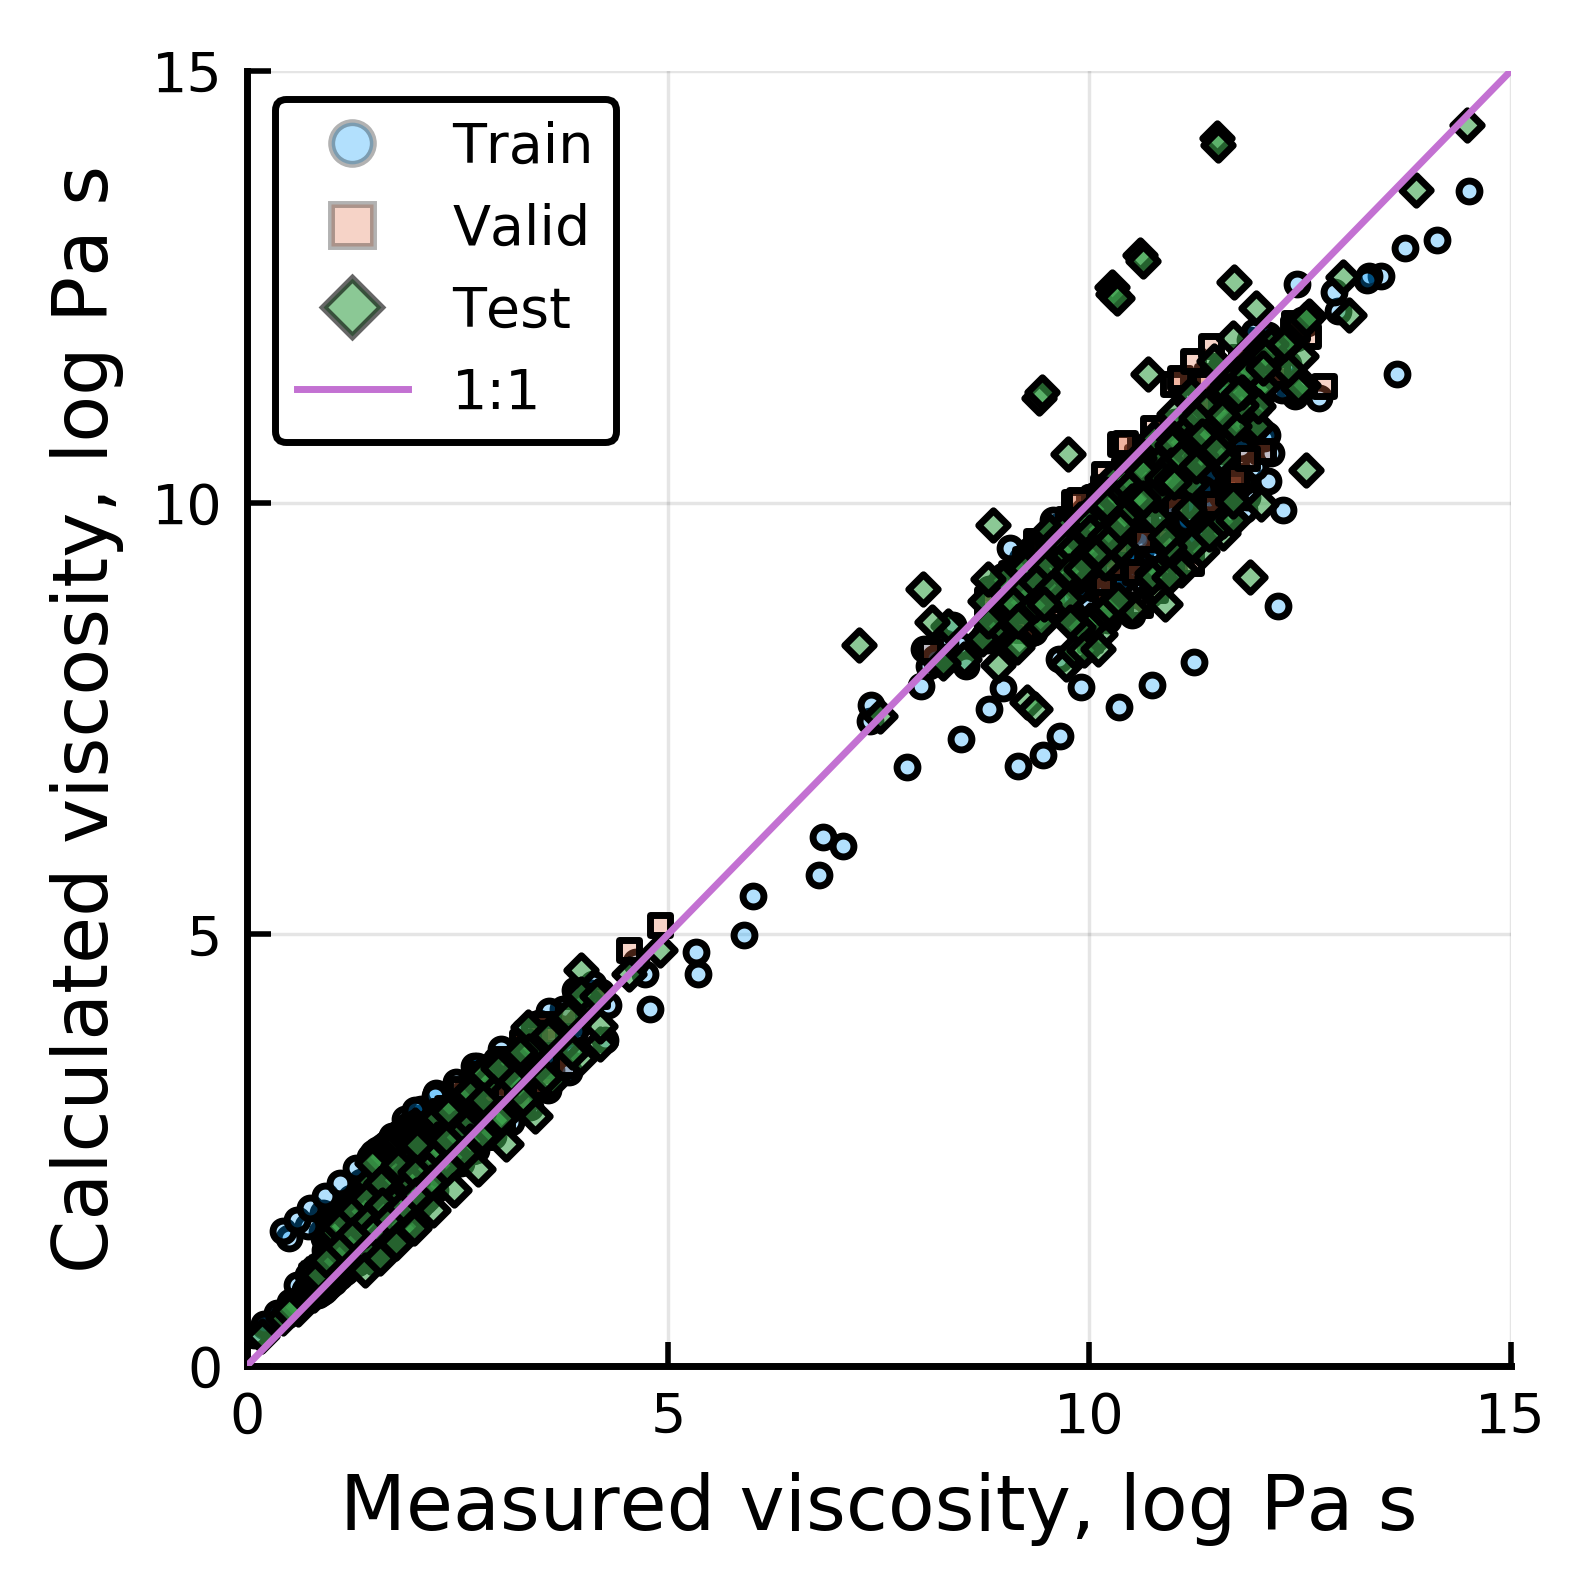


 MYEGA
0.696194047246219 (tracked)
0.5892141274876452 (tracked)
0.6912175440462519 (tracked)
Avramov-Mitchell
1.1564083349472591 (tracked)
0.9617482094784939 (tracked)
1.214451480508597 (tracked)
Adam-Gibbs
0.5820789953055158 (tracked)
0.5072835664991395 (tracked)
0.6579028084652352 (tracked)


In [17]:
#
# Load data
#
datas = load_data("./data/DataSet_0p20val.hdf5","./data/NKAS_DataSet.hdf5","./data/NKAS_density.hdf5")

#
# Load network
#
@load "./model/Ae4x100_1.bson" Ae
@load "./model/nnr4x100_1.bson" nnr
@load "./model/nns4x100_1.bson" nns
testmode!(nnr)
testmode!(nns)

x_train_, y_train_, T_train_, ap_train_, b_train_ = prepare_data(datas["X_train"],datas["y_train"])
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_ = prepare_data(datas["X_valid"],datas["y_valid"])
x_test_, y_test_, T_test_, ap_test_, b_test_ = prepare_data(datas["X_test"],datas["y_test"])

p1 = scatter(y_train_[:],
    myega(x_train_,T_train_, nns, Ae).data[:],
    label="Train",legend=:topleft,m=(3,0.3, :auto),
xlabel="Measured viscosity, log Pa s",
ylabel="Calculated viscosity, log Pa s",
xlim=(0,15),
ylim=(0,15),
dpi=500,
size=(300,300))

scatter!(y_valid_[:],
    myega(x_valid_,T_valid_,nns,Ae).data[:],label="Valid",m=(3,0.3, :auto))

scatter!(vec(y_test_),myega(x_test_,T_test_, nns, Ae).data[:],label="Test",m=(:diamond,3,0.6))

plot!([0.,16.],[0.,16.],label="1:1")
show()
savefig("./figures/KNAS_visco.png")

println("\n MYEGA")
println(loss_n_myega(x_train_,T_train_,y_train_,nns,Ae))
println(loss_n_myega(x_valid_,T_valid_,y_valid_,nns,Ae))
print(loss_n_myega(x_test_,T_test_,y_test_,nns,Ae))

println("\nAvramov-Mitchell")
println(loss_n_am(x_train_,T_train_,y_train_,nns,Ae))
println(loss_n_am(x_valid_,T_valid_,y_valid_,nns,Ae))
print(loss_n_am(x_test_,T_test_,y_test_,nns,Ae))

println("\nAdam-Gibbs")
println(loss_n_ag(x_train_,T_train_,ap_train_, b_train_,y_train_,nns,Ae))
println(loss_n_ag(x_valid_,T_valid_,ap_valid_, b_valid_,y_valid_,nns,Ae))
println(loss_n_ag(x_test_,T_test_,ap_test_, b_test_,y_test_,nns,Ae))

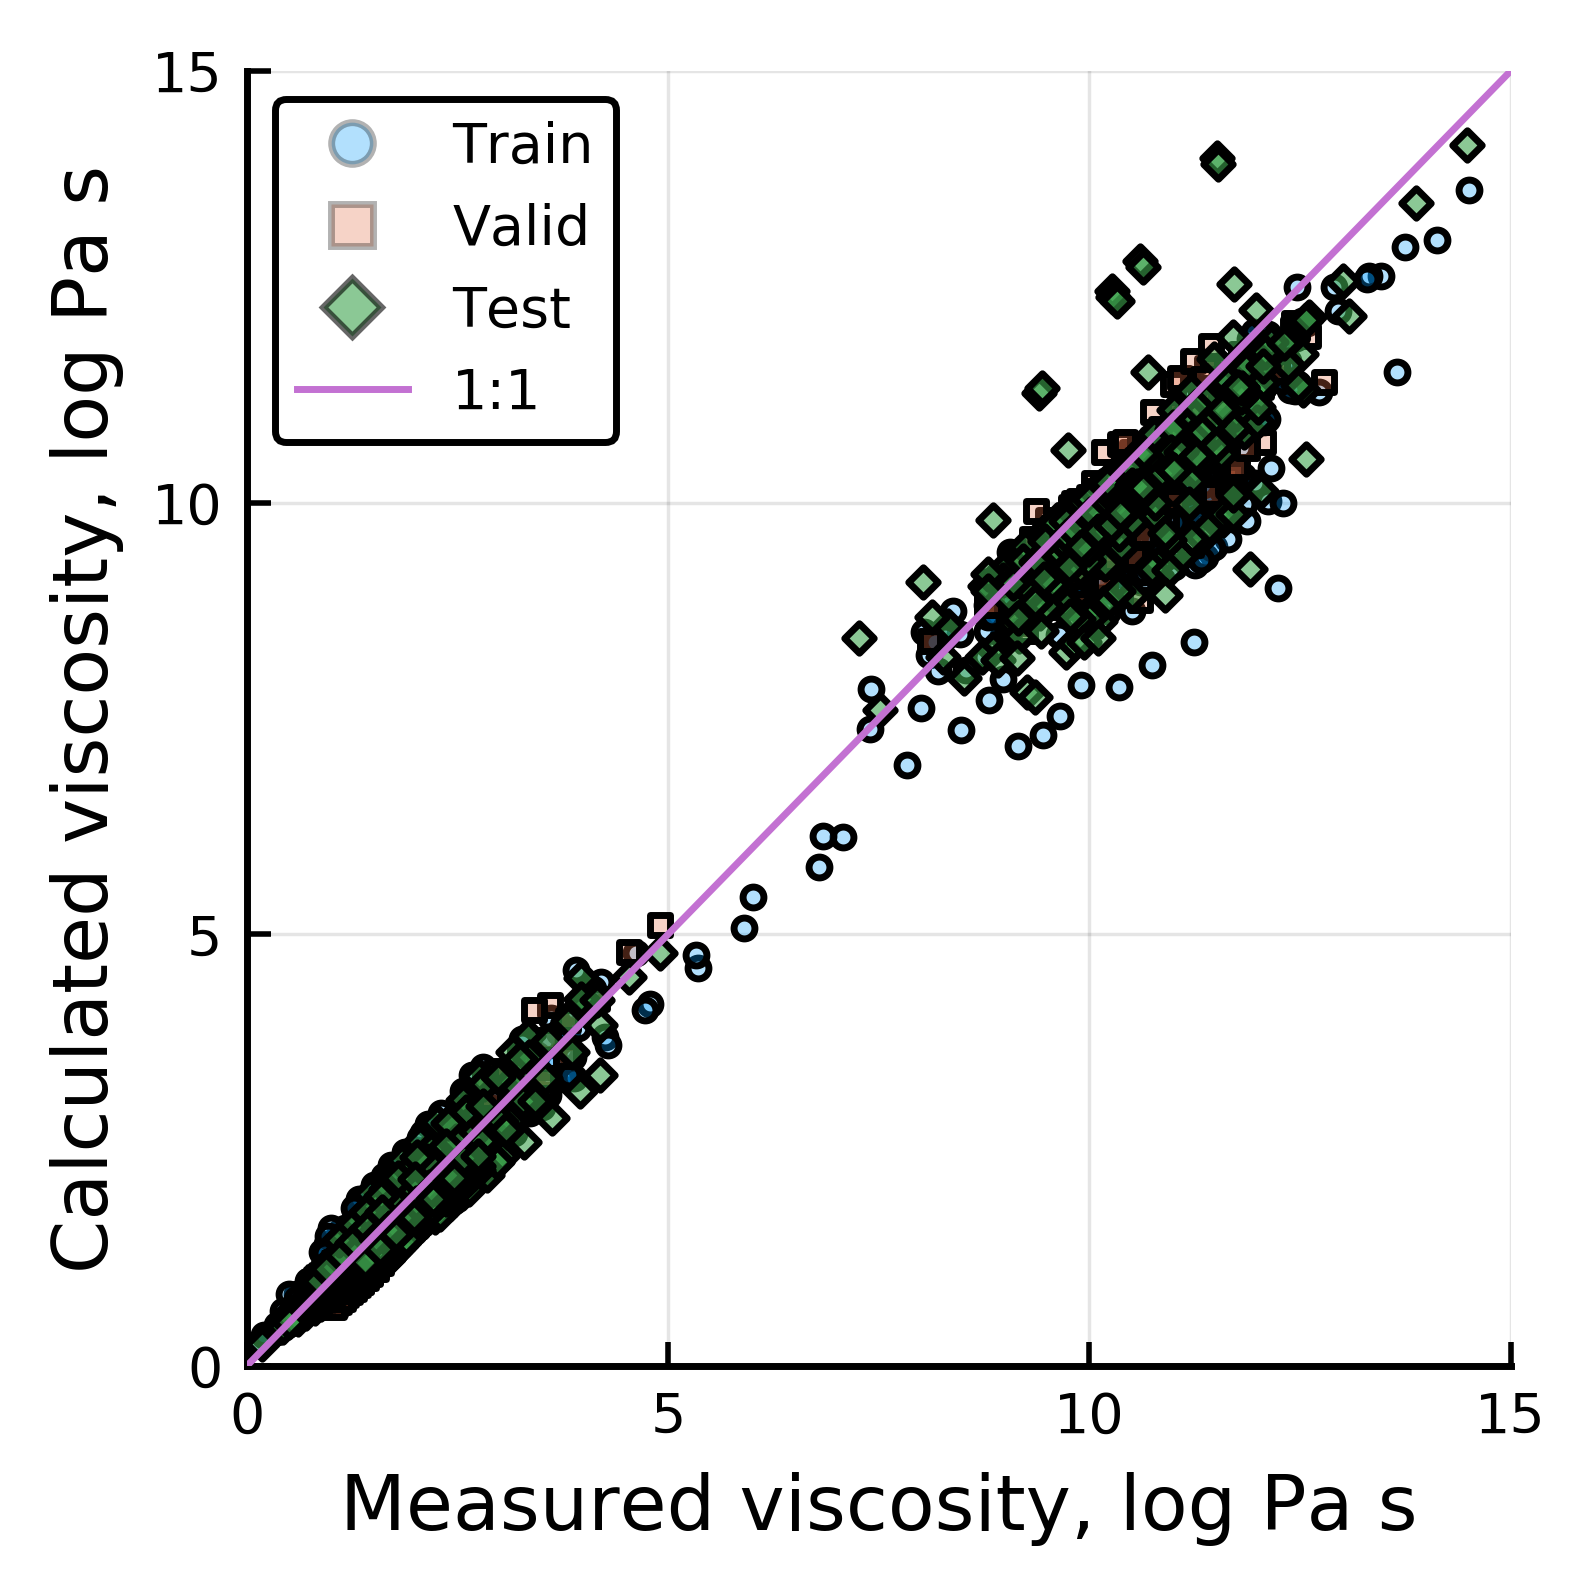

In [18]:
p2 = scatter(y_train_[:],
    ag(x_train_,T_train_,ap_train_, b_train_,nns,Ae).data[:],
    label="Train",legend=:topleft,m=(3,0.3, :auto),
xlabel="Measured viscosity, log Pa s",
ylabel="Calculated viscosity, log Pa s",
xlim=(0,15),
ylim=(0,15),
dpi=500,
size=(300,300))

scatter!(y_valid_[:],ag(x_valid_,T_valid_,ap_valid_, b_valid_,nns,Ae).data[:],
         label="Valid",m=(3,0.3, :auto))

scatter!(vec(y_test_),ag(x_test_,T_test_,ap_test_, b_test_,nns, Ae).data[:],
         label="Test",m=(:diamond,3,0.6))

plot!([0.,16.],[0.,16.],label="1:1")
show()
savefig("./figures/KNAS_AG_visco.png")

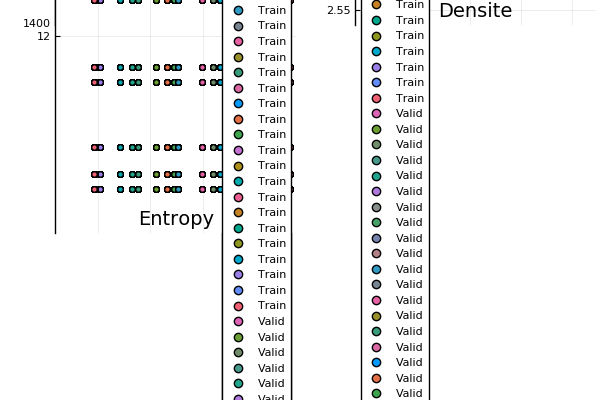

In [8]:
scatter([datas["y_tg_train"][:],datas["y_density_train"][:],datas["y_entropy_train"]], # x values
            [tg(datas["X_tg_train"],nns).data'[:],density(datas["X_density_train"],nns).data'[:],ScTg(datas["X_entropy_train"],nns).data'[:]], # y values
            layout=3, title=["Tg" "Densite" "Entropy"],label=["Train" "Train" "Train"],
            xlabel=["Measured" "Measured" "Measured"],ylabel=["Predicted" "Predicted" "Predicted"])

scatter!([datas["y_tg_valid"][:],datas["y_density_valid"][:],datas["y_entropy_valid"]], # x values
            [tg(datas["X_tg_valid"],nns).data'[:],density(datas["X_density_valid"],nns).data'[:],ScTg(datas["X_entropy_valid"],nns).data'[:]], # y values
            layout=3,label=["Valid" "Valid" "Valid"])

# Relationship Cp/Sc vs fragility 

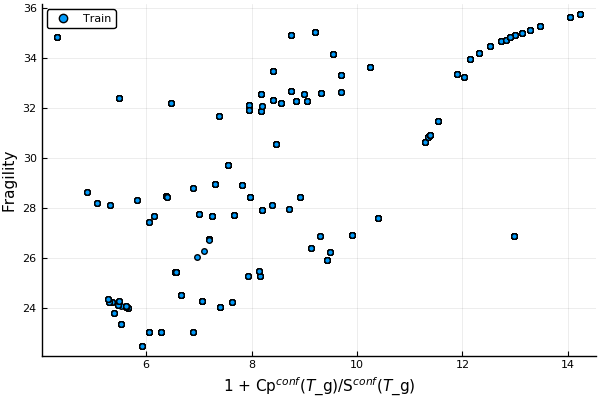

In [19]:
Cp_Tg_train =  ap_train_ .+ b_train_.*tg(x_train_,nns).data[:]'

scatter(Cp_Tg_train',fragility(x_train_,nns).data[:],
        xlabel=L"1 + Cp$^{conf}(T$_g$)$/S$^{conf}(T$_g$)$",
        ylabel="Fragility",
        label="Train")



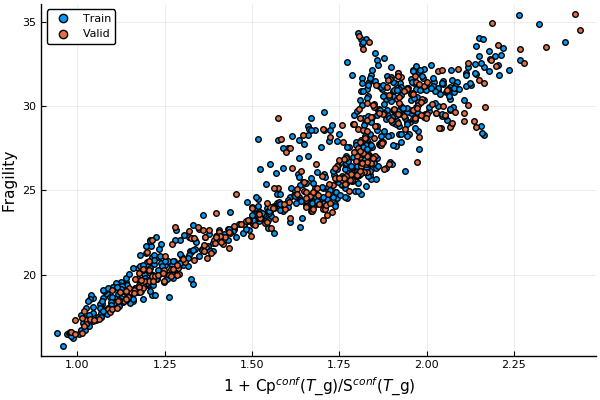

In [20]:
# Loading fake dataset
X_FragLoss_train = Float32.(h5read("./data/X_FragLoss.hdf5","X_train"))
ap_FragLoss_train = ap_calc(X_FragLoss_train)
b_FragLoss_train = b_calc(X_FragLoss_train)

X_FragLoss_valid = Float32.(h5read("./data/X_FragLoss.hdf5","X_valid"))
ap_FragLoss_valid = ap_calc(X_FragLoss_valid)
b_FragLoss_valid = b_calc(X_FragLoss_valid)

Cp_Tg_train = ap_FragLoss_train .+ b_FragLoss_train.*tg(X_FragLoss_train,nns).data[:]'
Cp_Tg_valid = ap_FragLoss_valid .+ b_FragLoss_valid.*tg(X_FragLoss_valid,nns).data[:]'

scatter(1.0.+Cp_Tg_train'./ScTg(X_FragLoss_train,nns).data[:],fragility(X_FragLoss_train,nns).data[:],
        xlabel=L"1 + Cp$^{conf}(T$_g$)$/S$^{conf}(T$_g$)$",
        ylabel="Fragility",
        label="Train")

scatter!(1.0.+Cp_Tg_valid'./ScTg(X_FragLoss_valid,nns).data[:],fragility(X_FragLoss_valid,nns).data[:],
        label="Valid")

# scatter!(1.0.+Cp_Tg_test'./ScTg(x_test_,nns).data[:],fragility(x_test_,nns).data[:],
#         label="Test")

# Entropy variations

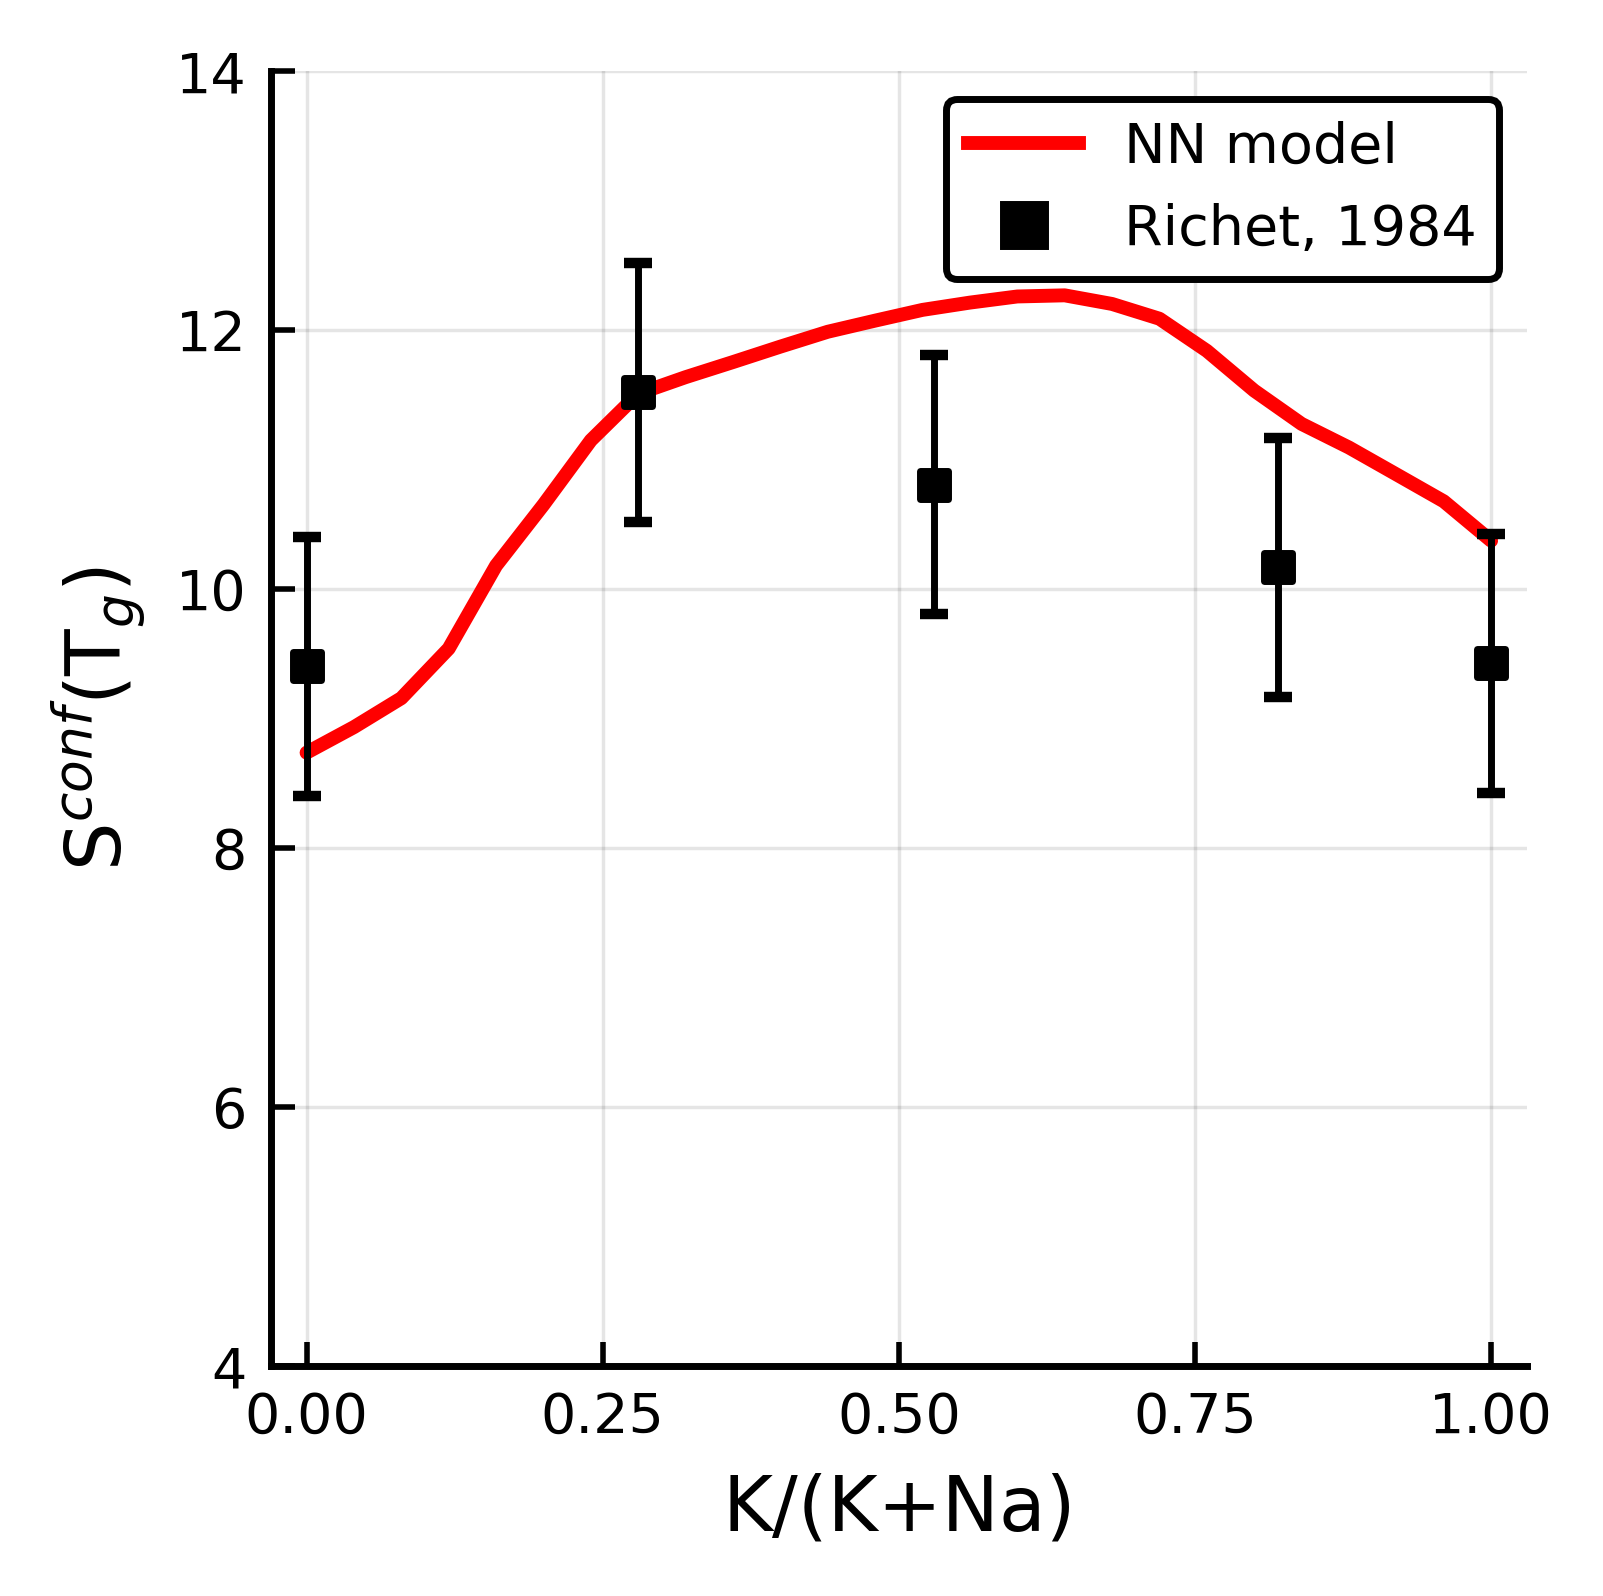

In [21]:
na2o = collect(0.:0.01:0.25)
k2o = 0.25.-na2o
sio2 = ones(size(na2o,1)).*0.75
al2o3 = zeros(size(na2o,1))

X_visu_ = [sio2 al2o3 na2o k2o]'[:,:]

plot(X_visu_[4,:]./(X_visu_[3,:].+X_visu_[4,:]),ScTg(X_visu_,nns).data'[:],
    line=("red",2),
    xlabel="K/(K+Na)",
    ylabel=L"S$^{conf}$(T$_g$)",
    ylim=(4,14),
    label="NN model",
    size=(300,300),dpi=500)
scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,
    err = 1.0,
    label="Richet, 1984",
    marker=(:square,"black",4),
    c = :black)

savefig("./figures/KNS_75_Sc.png")

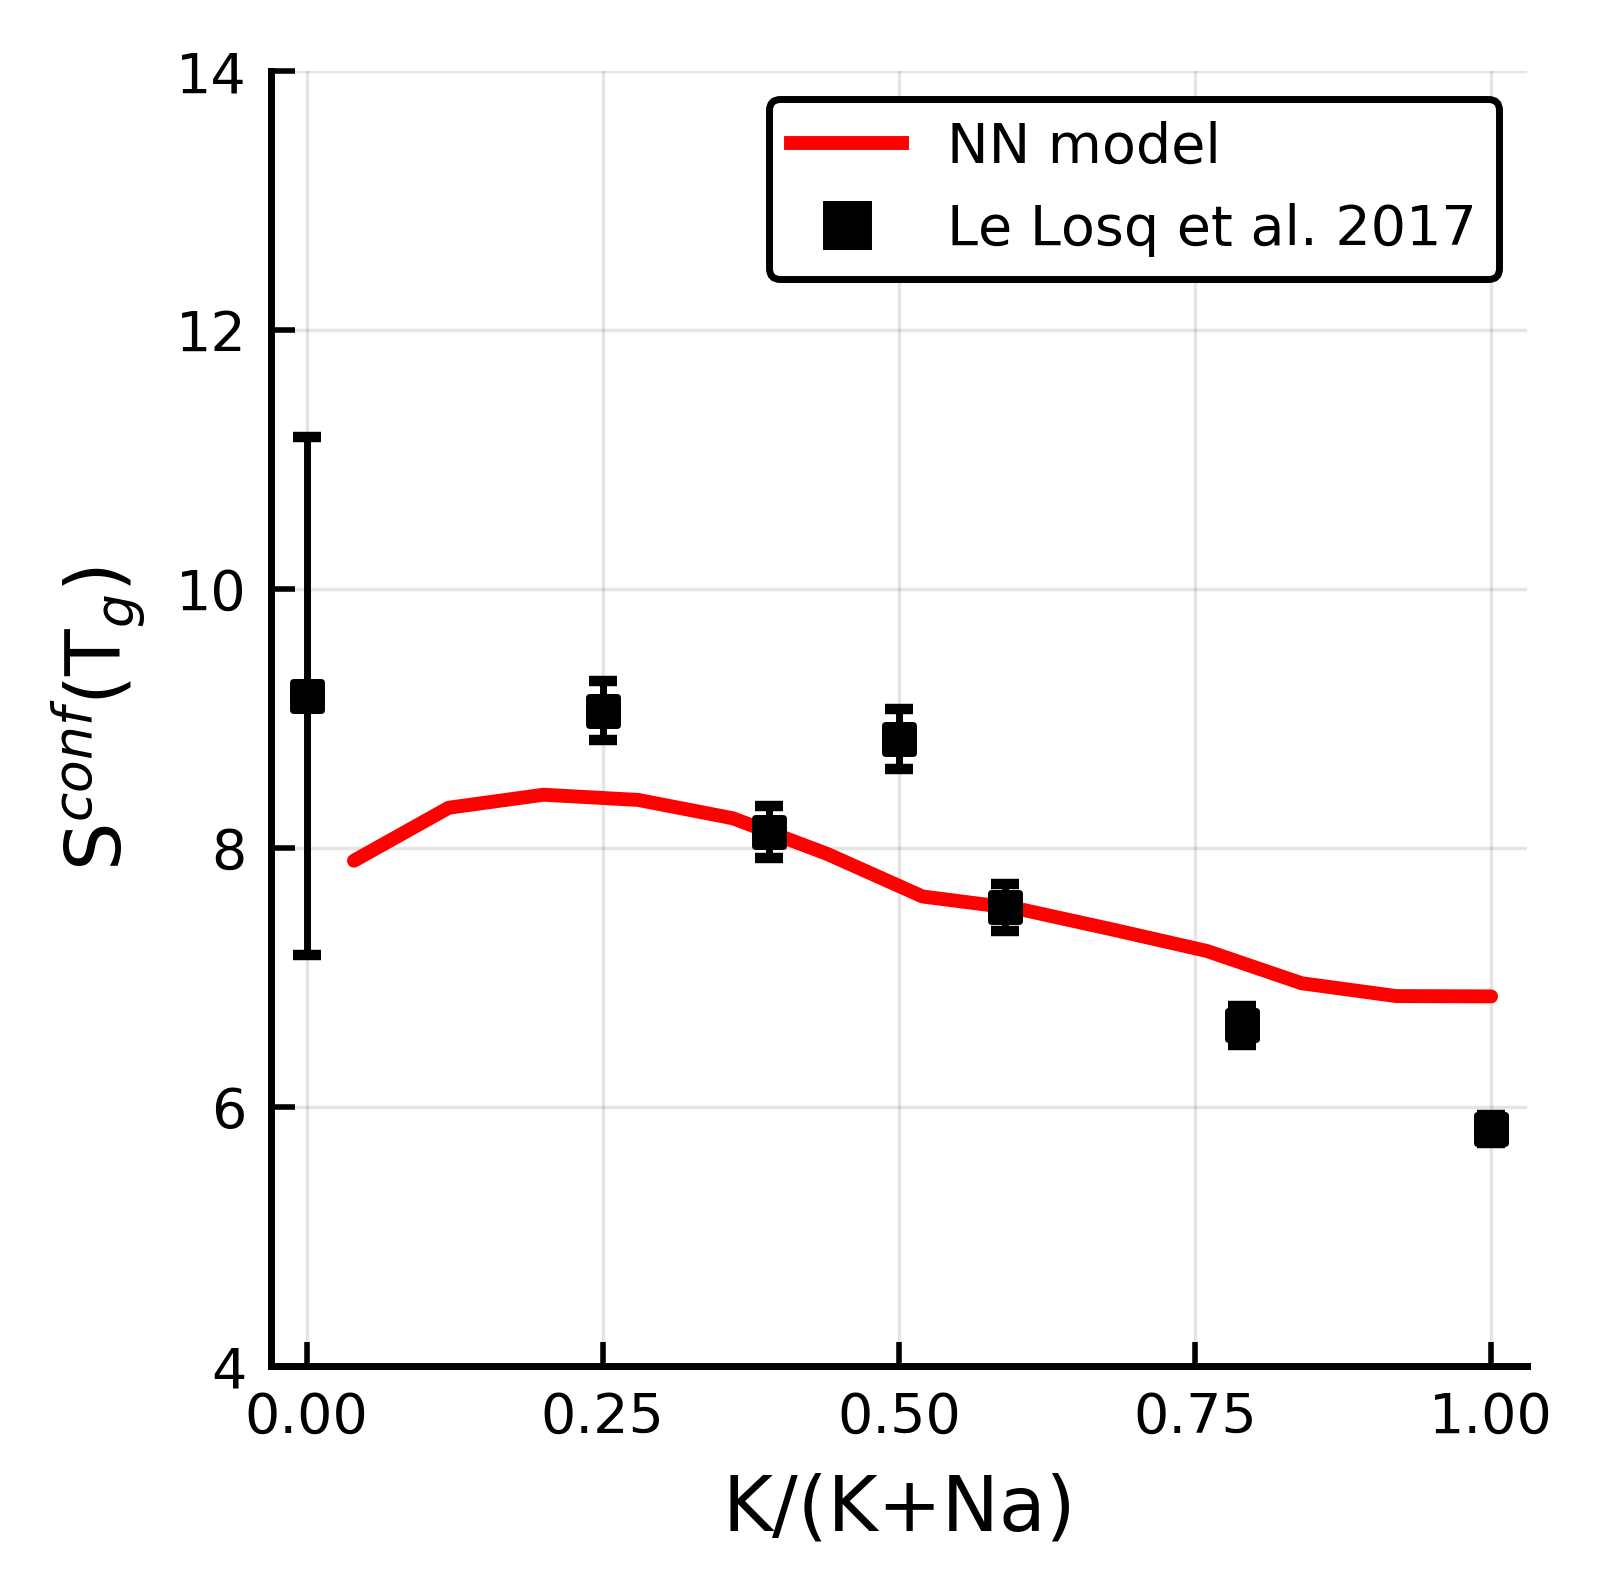

In [22]:
na2o = collect(0.:0.01:0.125)
k2o = 0.125.-na2o
sio2 = ones(size(na2o,1)).*0.75
al2o3 = ones(size(na2o,1)).*0.125

X_visu_ = [sio2 al2o3 na2o k2o]'[:,:]

plot(X_visu_[4,:]./(X_visu_[3,:].+X_visu_[4,:]),ScTg(X_visu_,nns).data'[:],
    line=("red",2),
    xlabel="K/(K+Na)",
    ylabel=L"S$^{conf}$(T$_g$)",
    label="NN model",
    ylim=(4,14),
    size=(300,300),dpi=500)
scatter!([0,0.25,0.39,0.50,0.59,0.79,1.00],[9.17,9.06,8.12,8.84,7.54,6.63,5.83],
    err = [2.,0.23,0.20,0.23,0.18,0.15,0.11],
    label="Le Losq et al. 2017",
    marker=(:square,"black",4),
    c = :black)

savefig("./figures/KNAS_75_Sc.png")

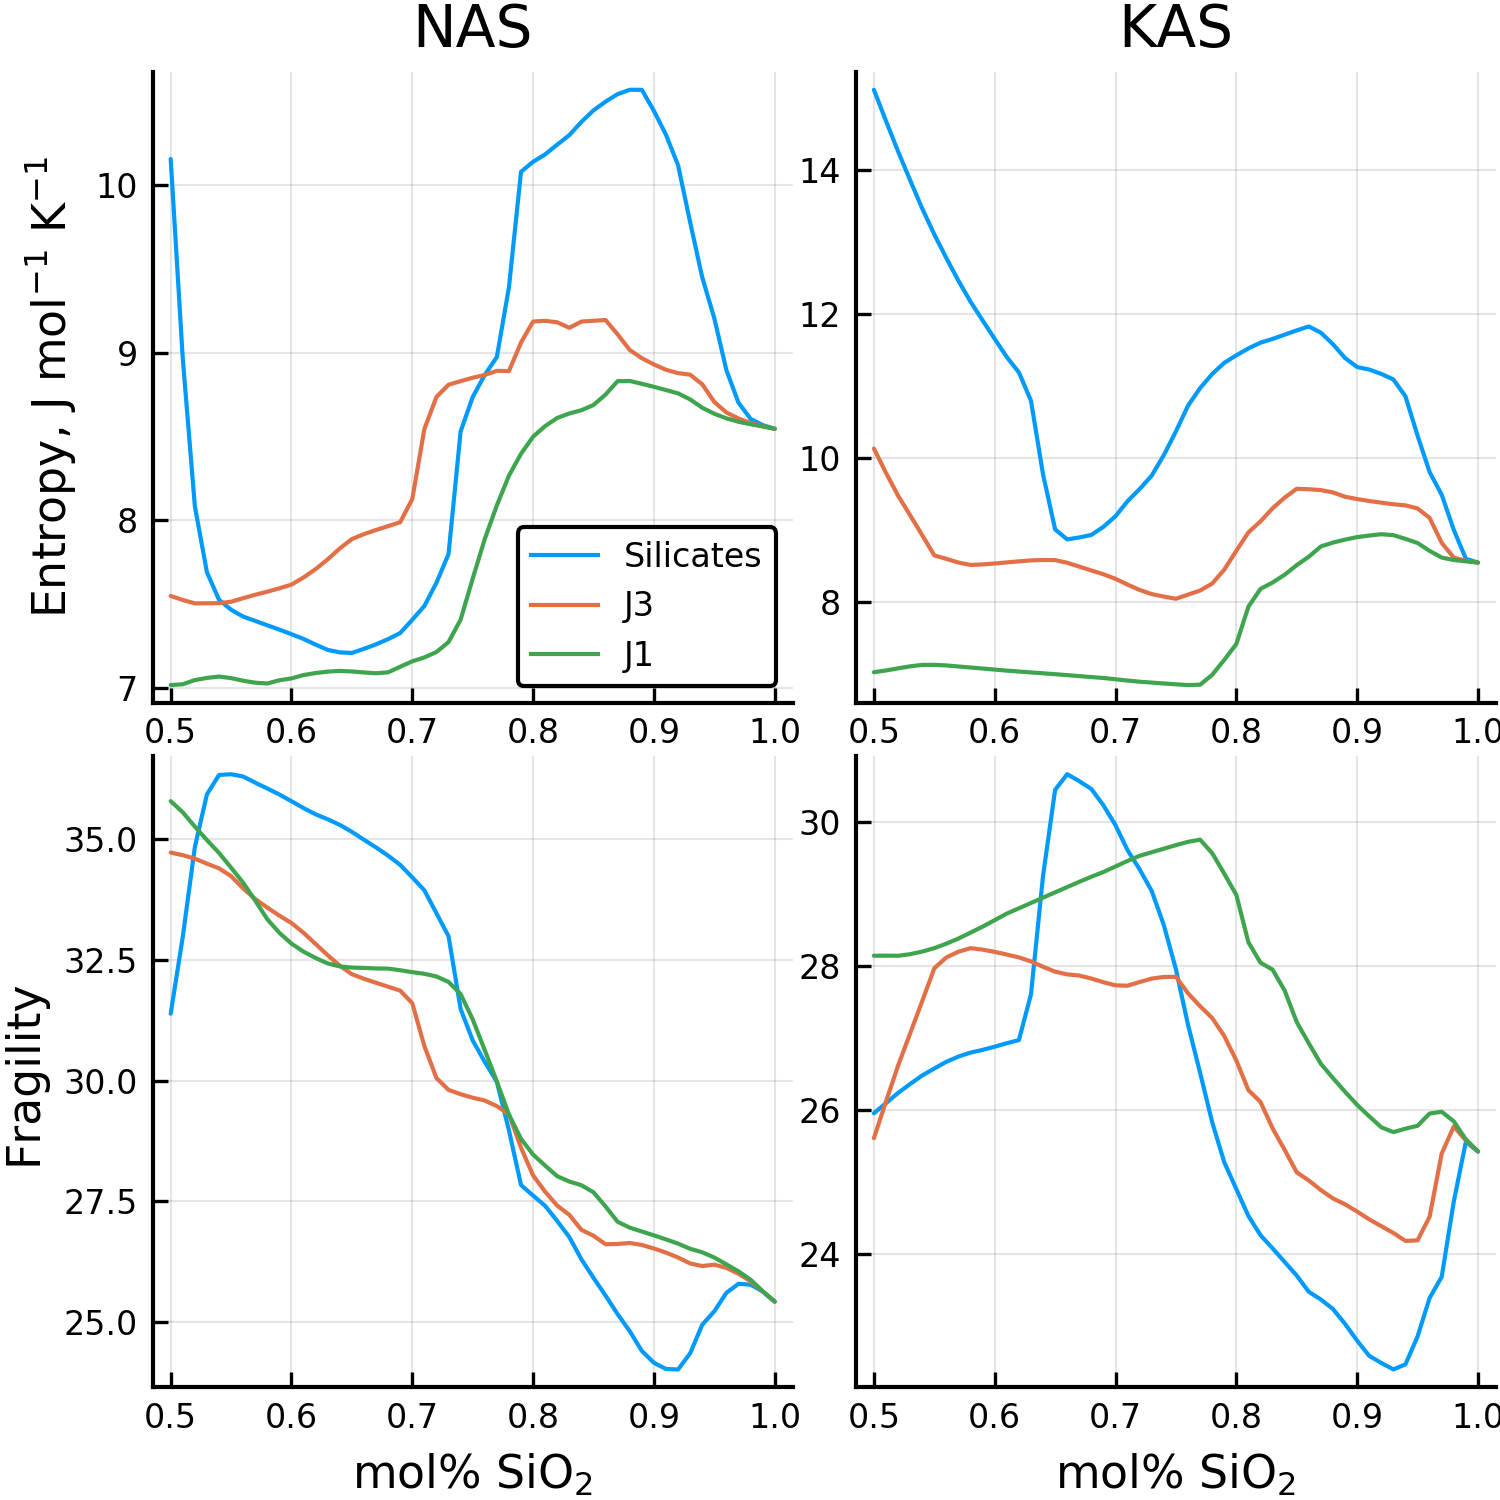

In [23]:
sio2 = collect(0.5:0.01:1.)

# order => sio2 al2o3 na2o k2o
X_visu_NAS_sili = [sio2 zeros(size(sio2,1)) 1.0.-sio2 zeros(size(sio2,1))]'
X_visu_NAS_J3 = [sio2 (1.0.-sio2).*1.0./3.0 (1.0.-sio2).*2.0./3.0 zeros(size(sio2,1))]'
X_visu_NAS_J1 = [sio2 (1.0.-sio2).*0.5 (1.0.-sio2).*0.5 zeros(size(sio2,1))]'

X_visu_KAS_sili = [sio2 zeros(size(sio2,1)) zeros(size(sio2,1)) 1.0.-sio2]'
X_visu_KAS_J3 = [sio2 (1.0.-sio2).*1.0./3.0 zeros(size(sio2,1)) (1.0.-sio2).*2.0./3.0]'
X_visu_KAS_J1 = [sio2 (1.0.-sio2).*0.5 zeros(size(sio2,1)) (1.0.-sio2).*0.5]'

plot([X_visu_NAS_sili[1,:] X_visu_NAS_J3[1,:] X_visu_NAS_J1[1,:]],
    [ScTg(X_visu_NAS_sili,nns).data'[:] ScTg(X_visu_NAS_J3,nns).data'[:] ScTg(X_visu_NAS_J1,nns).data'[:]],
     layout=4,subplot=1,label=["Silicates" "J3" "J1"],
     ylabel=L"Entropy, J mol$^{-1}$ K$^{-1}$",title="NAS",
     dpi=300,size=(500,500))

plot!([X_visu_KAS_sili[1,:] X_visu_KAS_J3[1,:] X_visu_KAS_J1[1,:]],
    [ScTg(X_visu_KAS_sili,nns).data'[:] ScTg(X_visu_KAS_J3,nns).data'[:] ScTg(X_visu_KAS_J1,nns).data'[:]],
     subplot=2,label=["Silicates" "J3" "J1"],legend=false,
    title="KAS")

plot!([X_visu_NAS_sili[1,:] X_visu_NAS_J3[1,:] X_visu_NAS_J1[1,:]],
    [fragility(X_visu_NAS_sili,nns).data'[:] fragility(X_visu_NAS_J3,nns).data'[:] fragility(X_visu_NAS_J1,nns).data'[:]],
     subplot=3,label=["Silicates" "J3" "J1"],legend=false,
     xlabel=L"mol% SiO$_2$",ylabel="Fragility")

plot!([X_visu_KAS_sili[1,:] X_visu_KAS_J3[1,:] X_visu_KAS_J1[1,:]],
    [fragility(X_visu_KAS_sili,nns).data'[:] fragility(X_visu_KAS_J3,nns).data'[:] fragility(X_visu_KAS_J1,nns).data'[:]],
     subplot=4,label=["Silicates" "J3" "J1"],legend=false,
    xlabel=L"mol% SiO$_2$")

In [14]:
log(10.0)

2.302585092994046

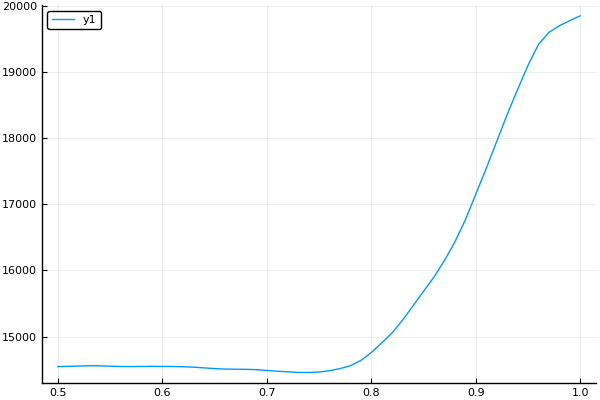

In [18]:
sio2 = collect(0.5:0.01:1.)
al2o3 = (1.0.-sio2)./2.0
na2o = copy(al2o3)
k2o = zeros(size(sio2,1))
dummy = zeros(size(sio2,1))
T = ones(size(sio2,1)).*1000.0
X_visu_ = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'


plot(X_visu_[1,:],
    Be(X_visu_).data'[:]./ScTg(X_visu_).data'[:],
layout=1)


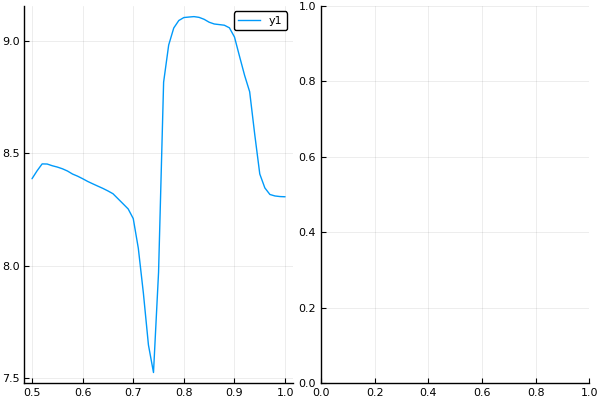

In [85]:
sio2 = collect(0.5:0.01:1.)
al2o3 = (1.0.-sio2)./2.0
na2o = copy(al2o3)
k2o = zeros(size(sio2,1))
dummy = zeros(size(sio2,1))
T = ones(size(sio2,1)).*1000.0
X_visu_ = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'


plot([X_visu_[1,:]],
    [ScTg(X_visu_,nns).data'[:]],
layout=2)


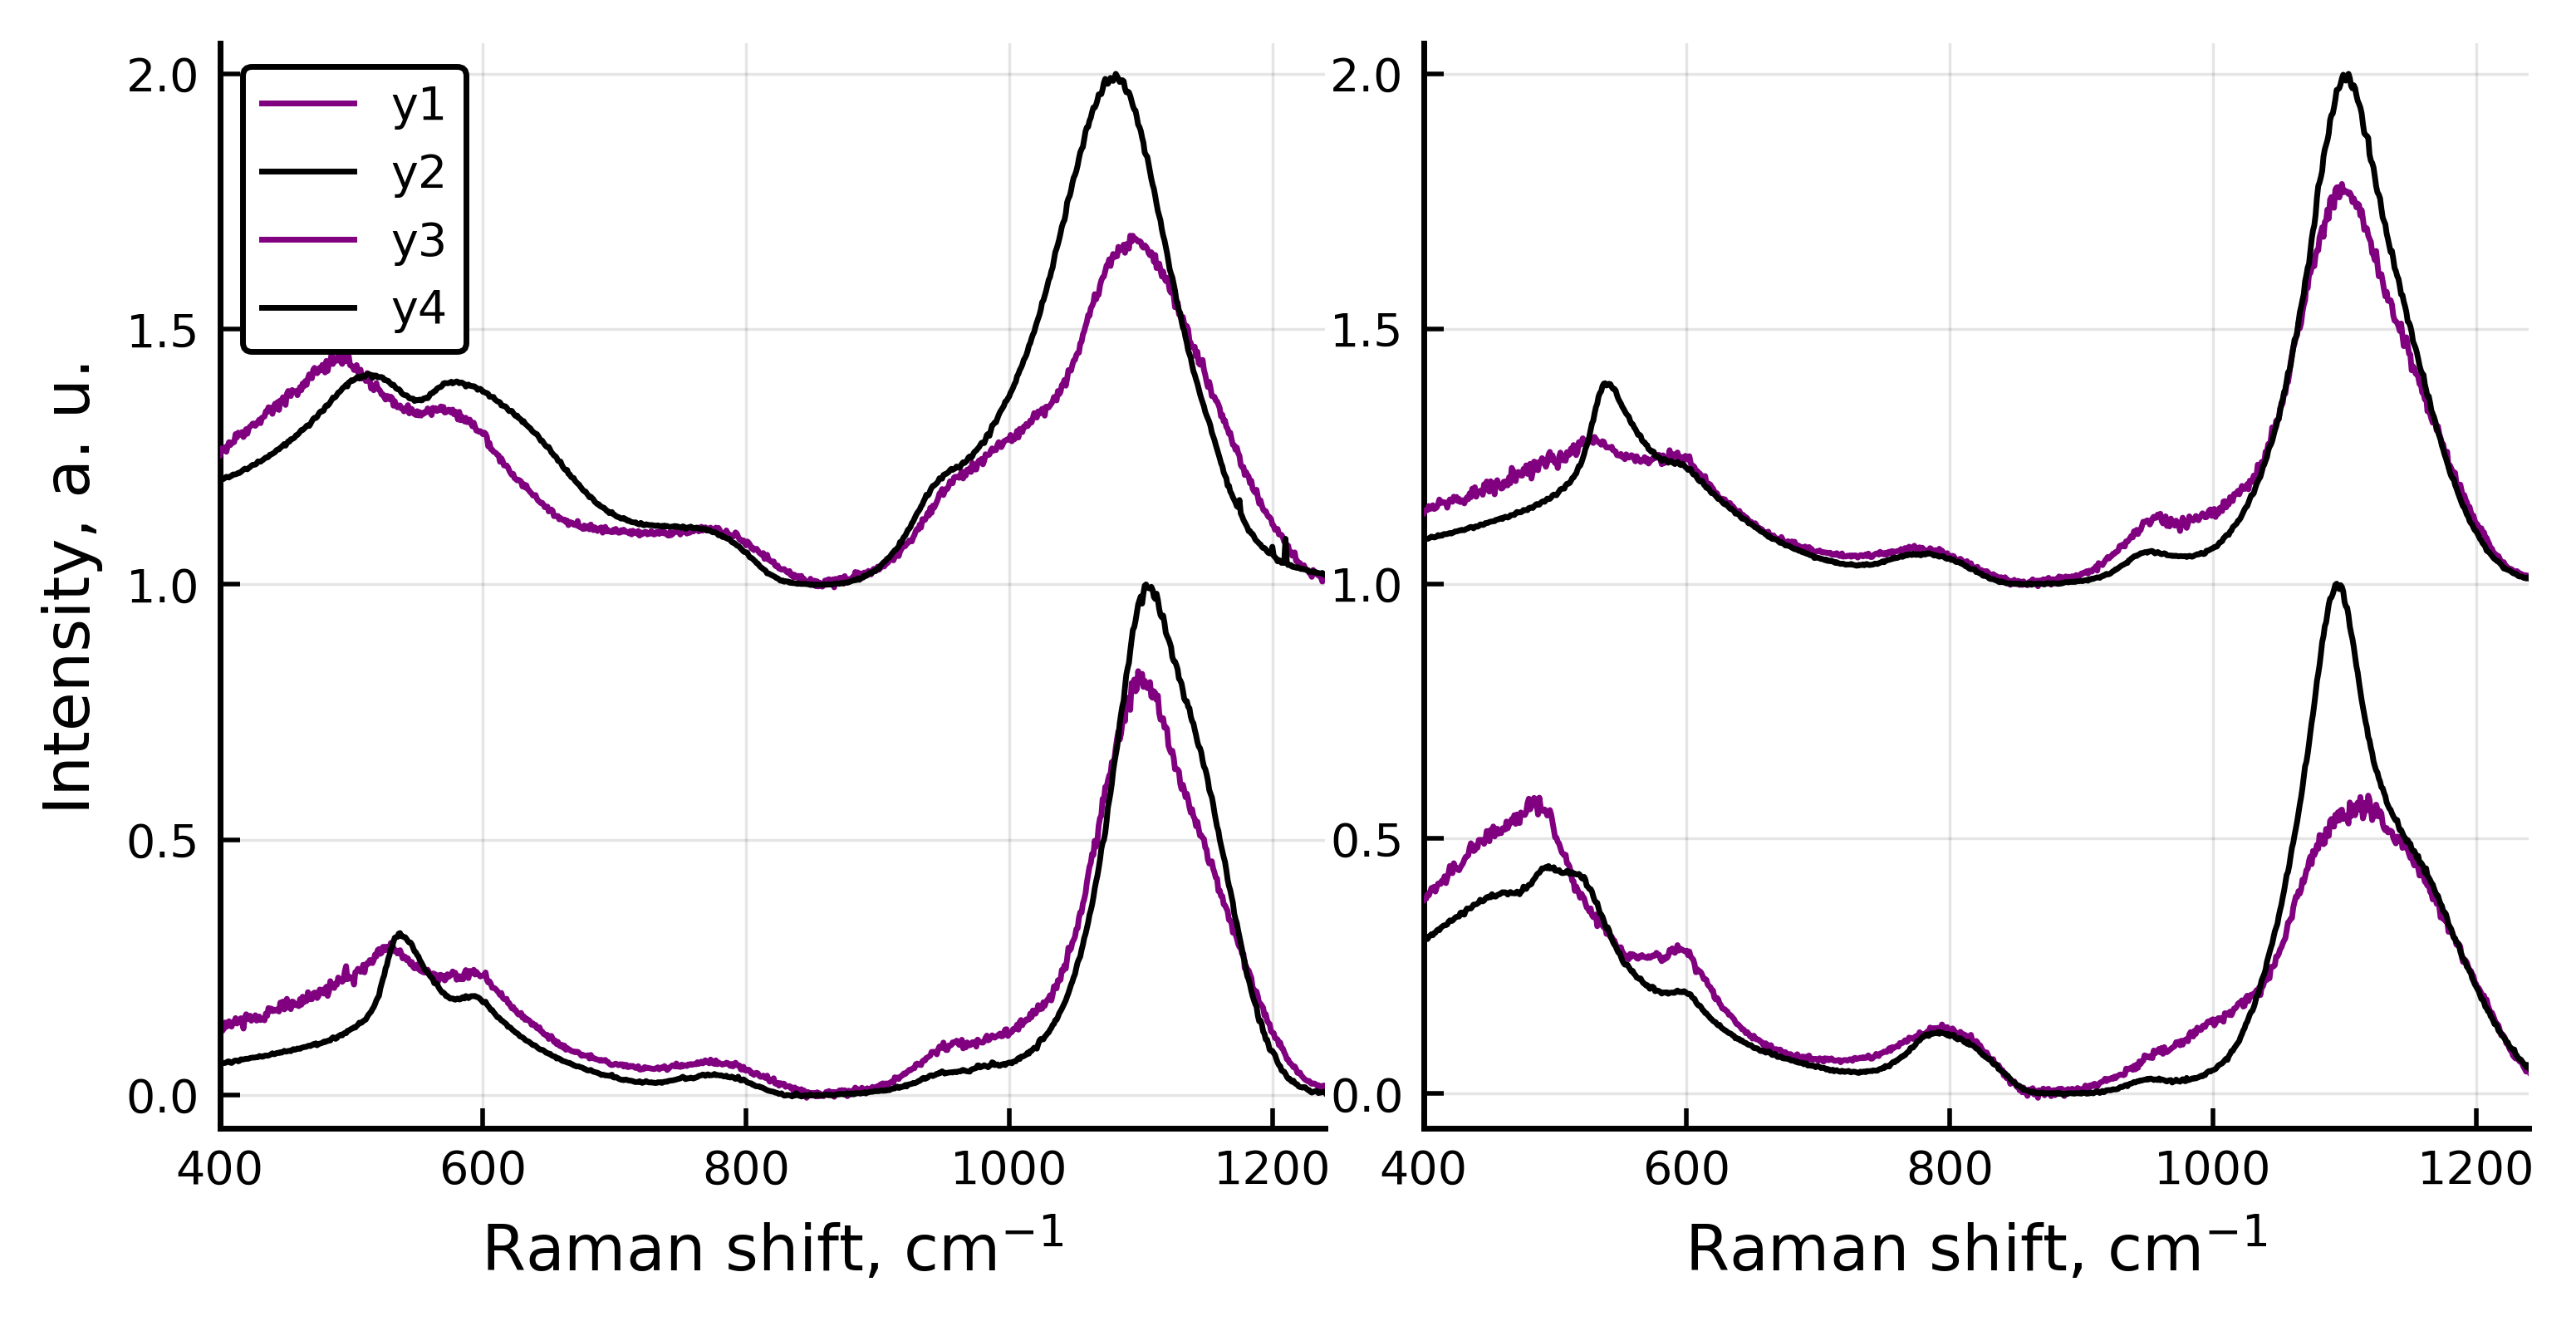

In [69]:
frequency = collect(400.:1.:1250.)

plot(frequency,nnr(datas["X_raman_valid"]).data[:,4], layout=2, 
    xlabel=L"Raman shift, cm$^{-1}$", ylabel="Intensity, a. u.",
    color=:purple,
    xlim=(400,1240),
    size=(600,300),dpi=500)

plot!(frequency,datas["y_raman_valid"][:,4],color=:black)

plot!(frequency,nnr(datas["X_raman_valid"]).data[:,10].+1.,color=:purple)
plot!(frequency,datas["y_raman_valid"][:,10].+1.,color=:black)

plot!(frequency,nnr(datas["X_raman_valid"]).data[:,7],color=:purple, 
    subplot=2,xlabel=L"Raman shift, cm$^{-1}$",xlim=(400,1240),legend=false)

plot!(frequency,datas["y_raman_valid"][:,7],color=:black, subplot=2)

plot!(frequency,nnr(datas["X_raman_valid"]).data[:,9].+1.,color=:purple, subplot=2)
plot!(frequency,datas["y_raman_valid"][:,9].+1.,color=:black, subplot=2)
savefig("./figures/ANN_Raman_examples.png")